# Evaluate Fisher information

Johann Brehmer, Kyle Cranmer, Felix Kling, Duccio Pappadopulo, Josh Ruderman 2018

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
% matplotlib inline
import logging
import os

import madminer.core
from madminer.fisherinformation import FisherInformation
from madminer.plotting import plot_fisher_information_contours_2d

logging.basicConfig(format='%(asctime)s  %(message)s', datefmt='%H:%M')

In [2]:
base_dir = '/Users/johannbrehmer/work/projects/madminer/diboson_mining/'
mg_dir = '/Users/johannbrehmer/work/projects/madminer/MG5_aMC_v2_6_2/'

In [3]:
sample_dir = base_dir + 'data/samples/wgamma/'
card_dir = base_dir + 'cards/wgamma/'
ufo_model_dir = card_dir + 'SMWgamma_UFO'
run_card_dir = card_dir + 'run_cards/'
mg_process_dir = base_dir + 'data/mg_processes/wgamma/'
log_dir = base_dir + 'logs/wgamma/'
temp_dir = base_dir + 'data/temp'
delphes_dir = mg_dir + 'Delphes'
model_dir = base_dir + 'data/models/wgamma/'

## FisherInformation instance

In [4]:
fisher = FisherInformation(sample_dir + 'samples.h5', debug=True)

16:00  
16:00  ------------------------------------------------------------
16:00  |                                                          |
16:00  |  MadMiner v2018.10.12                                    |
16:00  |                                                          |
16:00  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
16:00  |                                                          |
16:00  ------------------------------------------------------------
16:00  
16:00  Loading data from /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/samples/wgamma/samples.h5
16:00  Found 2 parameters:
16:00     cWWW (LHA: dim6 1, maximal power in squared ME: (2,), range: (-0.1, 0.1))
16:00     cWWWtilde (LHA: dim6 2, maximal power in squared ME: (2,), range: (-0.1, 0.1))
16:00  Found 6 benchmarks:
16:00     sm: cWWW = 0.00e+00, cWWWtilde = 0.00e+00
16:00     morphing_basis_vector_1: cWWW = -9.39e-02, cWWWtilde = 0.07
16:00     morphing_basis_vector_2: cWWW = 0.

## ML vs histogram check

### Calculate Fisher information for different versions of a delta phi histo

In [5]:
obs_min = 0.
obs_max = 6.
n_bins = [10,25,50,100]

fisher_infos_histogram_variations = []
for bins in n_bins:
    fisher_infos_histogram_variations.append(
        fisher.calculate_fisher_information_hist1d(
            theta=[0.,0.],
            luminosity=300000.,
            observable='deltaphi_l1_a1',
            nbins=bins,
            histrange=(obs_min, obs_max)
        )
    )

/Users/johannbrehmer/work/projects/madminer/madminer/madminer/fisherinformation.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  fisher_info.append(luminosity / sigma[i_event] * np.tensordot(dsigma.T[i_event], dsigma.T[i_event], axes=0))
/Users/johannbrehmer/work/projects/madminer/madminer/madminer/fisherinformation.py:293: RuntimeWarning: invalid value encountered in multiply
  fisher_info.append(luminosity / sigma[i_event] * np.tensordot(dsigma.T[i_event], dsigma.T[i_event], axes=0))


### Estimate the Fisher information in delta phi with ML

In [6]:
model_filenames = ['sally_pta_1', 'sally_pta_2', 'sally_pta_big_1', 'sally_pta_big_2']
sample_filenames = ['test', 'test', 'all', 'all']
fisher_infos_detector_variations = []

for filename, sample_filename in zip(model_filenames, sample_filenames):
    fisher_infos_detector_variations.append(
        fisher.calculate_fisher_information_full_detector(
            theta=[0.,0.],
            luminosity=300000.,
            model_file=model_dir + filename,
            unweighted_x_sample_file = sample_dir + sample_filename + '_local/x_' + sample_filename + '.npy'
        )
    )


16:12  
16:12  ------------------------------------------------------------
16:12  |                                                          |
16:12  |  MadMiner v2018.10.12                                    |
16:12  |                                                          |
16:12  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
16:12  |                                                          |
16:12  ------------------------------------------------------------
16:12  
16:12  Loading settings from /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/models/wgamma/sally_pta_1_settings.json
16:12    Found method sally, 1 observables, 2 parameters, (100, 100, 100) hidden layers, tanh activation function, features [9]
16:12  Loading state dictionary from /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/models/wgamma/sally_pta_1_state_dict.pt
16:12  Loading evaluation data
16:12  Starting score evaluation
16:12  Expected score (should be close to 

### Plots

In [7]:
fisher_infos = np.array(
    fisher_infos_histogram_variations
    + fisher_infos_detector_variations
)
labels = [
    '10 bins', '25 bins', '50 bins', '100 bins',
    'ML split', 'ML split', 'ML all', 'ML all'
]
colors = ['C0', 'C0', 'C0', 'C0',
         'C1', 'C1', 'C1', 'C1']
linestyles = [':', '-.', '--', '-',
              '--', '--', '-', '-']

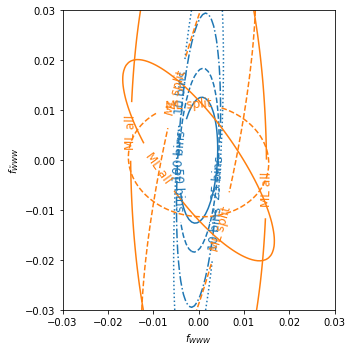

In [11]:
xmax = 0.03

fig = plot_fisher_information_contours_2d(
    fisher_information_matrices=100. / 300. * fisher_infos,
    contour_distance=1.,
    xrange=(-xmax,xmax),
    yrange=(-xmax,xmax),
    xlabel=r'$f_{WWW}$',
    ylabel=r'$f_{\tilde{W}WW}$',
    matrix_labels=labels,
    colors=colors,
    linestyles=linestyles
)

plt.show()
plt.savefig('ml_vs_histo_check.pdf')

## Compare all methods

### Calculate Fisher information: truth

In [10]:
fisher_info_xsec = fisher.calculate_fisher_information_rate(
    theta=[0.,0.],
    luminosity = 300000.
)

In [11]:
fisher_info_truth = fisher.calculate_fisher_information_full_truth(
    theta=[0.,0.],
    luminosity = 300000.
)

### Calculate Fisher information: various histograms

In [ ]:
observables = ['et_miss', 'pt_l1', 'pt_a1']
obs_mins = [20., 20., 20.]
obs_maxs = [500., 500., 500.]
bins = 48

fisher_infos_histograms = []
for observable, obs_min, obs_max in zip(observables, obs_mins, obs_maxs):
    fisher_infos_histograms.append(
        fisher.calculate_fisher_information_hist1d(
            theta=[0.,0.],
            luminosity=300000.,
            observable=observable,
            nbins=bins,
            histrange=(obs_min,obs_max)
        )
    )

### Calculate Fisher information: ML trained on different observables

In [9]:
model_filenames = ['sally_all', 'sally_met', 'sally_ptl', 'sally_pta', 'sally_pts', 'sally_deltaphis']
fisher_infos_detector = []

for filename in model_filenames:
    fisher_infos_detector.append(
        fisher.calculate_fisher_information_full_detector(
            theta=[0.,0.],
            luminosity=300000.,
            model_file=model_dir + filename,
            unweighted_x_sample_file = sample_dir + 'test_local/x_test.npy'
        )
    )

15:15  
15:15  ------------------------------------------------------------
15:15  |                                                          |
15:15  |  MadMiner v2018.10.12                                    |
15:15  |                                                          |
15:15  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
15:15  |                                                          |
15:15  ------------------------------------------------------------
15:15  
15:15  Loading settings from /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/models/wgamma/sally_all_settings.json
15:15    Found method sally, 27 observables, 2 parameters, (100, 100, 100) hidden layers, tanh activation function, features None
15:15  Loading state dictionary from /Users/johannbrehmer/work/projects/madminer/diboson_mining/data/models/wgamma/sally_all_state_dict.pt
15:15  Loading evaluation data
15:15  Starting score evaluation
15:15  Expected score (should be close to ze

### Fisher information contours

In [11]:
fisher_infos = np.array(
    [fisher_info_truth, fisher_info_xsec]
    + list(fisher_infos_histograms)
    +  list(fisher_infos_detector)
)
labels = [
    'truth: all', 'xsec',
    'Histo: MET', r'Histo: $p_{T, \ell}$', r'Histo: $p_{T, \gamma}$',
    'ML: all', 'ML: MET', r'ML: $p_{T, \ell}$', r'ML: $p_{T, \gamma}$', r'ML: all $p_{T}$', r'ML: all $\Delta \phi$'
]


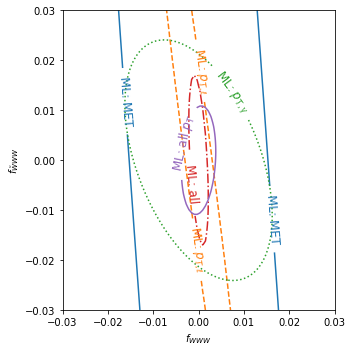

In [27]:
indices = [6,7,8,5,9]
#indices = [3,7]
#indices = [4,8]
xmax = 0.03

fig = plot_fisher_information_contours_2d(
    fisher_information_matrices=100. / 300. * fisher_infos[indices],
    contour_distance=1.,
    xrange=(-xmax,xmax),
    yrange=(-xmax,xmax),
    xlabel=r'$f_{WWW}$',
    ylabel=r'$f_{\tilde{W}WW}$',
    matrix_labels=[labels[i] for i in indices]
)

#plt.savefig('first_plot_wgamma.pdf')